In [146]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 20 22:00:45 2016

Reads a list of events by date and plots a moving average and day of the 
week histogram.

@author: Dario Arcos-Diaz
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Paired')
sns.set_style("whitegrid")
%matplotlib inline

In [152]:
df1 = pd.read_csv('~/Documents/event_earthquake.csv', header=None)
del df1[0]
df1.columns = ['Date']
df1['Event1'] = np.ones(len(df1))
df1.head()

,Date,Event1
0,2016-12-09,1.0
1,2016-12-08,1.0
2,2016-12-08,1.0
3,2016-12-06,1.0
4,2016-11-25,1.0


In [161]:
# Read the event series 2
df2 = pd.read_csv('~/Documents/filmreleasecount.csv', header=0)
del df2['Unnamed: 0']
df2.columns = ['Date', 'Event2']
df2.head()

,Date,Event2
0,2015-01-09,1.0
1,2015-01-16,3.0
2,2015-01-23,3.0
3,2015-01-30,3.0
4,2015-02-06,3.0


In [162]:
# Concatenate both dataframes into one
df = pd.concat([df1, df2], ignore_index=True)
df = df.set_index(pd.DatetimeIndex(df.Date))
df = df.sort_index()
df = df.resample('1d').sum().fillna(0) # to complete every day
df.head(10)

,Event1,Event2
Date,,
2015-01-09,0.0,1.0
2015-01-10,0.0,0.0
2015-01-11,0.0,0.0
2015-01-12,0.0,0.0
2015-01-13,0.0,0.0
2015-01-14,0.0,0.0
2015-01-15,0.0,0.0
2015-01-16,0.0,3.0
2015-01-17,0.0,0.0


In [163]:
# Calculate moving average
for i in [7*4, 7*4*2]:
    mvav = i # moving average period, i.e. number of points to average
    dfi = np.convolve(df['Event1'], 
                      np.ones((mvav,))*7/mvav # factor for obtaining average
                      , mode='full')
    df['Event1 Moving average %sw' % (int(i/7))] = dfi[:-(i-1)]
    dfj = np.convolve(df['Event2'], 
                      np.ones((mvav,))*7/mvav # factor for obtaining average
                      , mode='full')
    df['Event2 Moving average %sw' % (int(i/7))] = dfj[:-(i-1)]
df.head()

,Event1,Event2,Event1 Moving average 4w,Event2 Moving average 4w,Event1 Moving average 8w,Event2 Moving average 8w
Date,,,,,,
2015-01-09,0.0,1.0,0.0,0.25,0.0,0.125
2015-01-10,0.0,0.0,0.0,0.25,0.0,0.125
2015-01-11,0.0,0.0,0.0,0.25,0.0,0.125
2015-01-12,0.0,0.0,0.0,0.25,0.0,0.125
2015-01-13,0.0,0.0,0.0,0.25,0.0,0.125


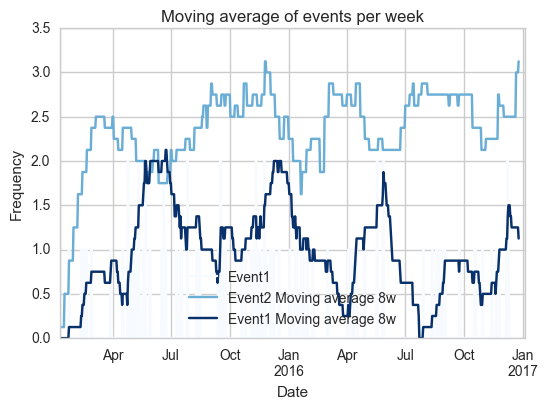

In [164]:
# Plot relevant columns from dataframe
df.loc[:,['Event1', 'Event2 Moving average 8w', 'Event1 Moving average 8w']].\
plot(cmap='Blues') #figsize=(8,4) possible
plt.xlim(df.index[0], df.index.max()+10)
plt.title('Moving average of events per week')
plt.ylabel('Frequency')
plt.show()

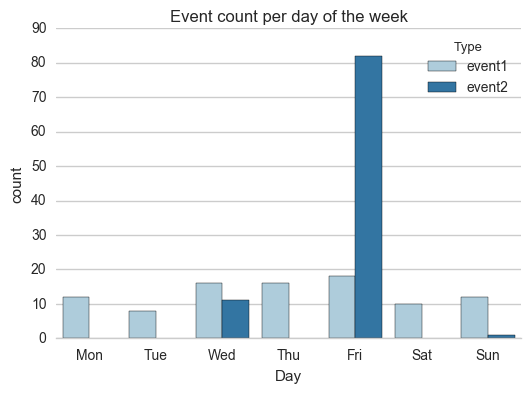

In [165]:
#%% DAY OF THE WEEK ANALYSIS

# create column for day of the week
df['Day'] = df.index.dayofweek
df['Day'] = df.Day.astype('category')
df.Day.cat.categories = ['Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# create column for type
df['Type'] = np.where(df['Event1']>0, 'event1', np.where(df['Event2']>0,\
 'event2', np.nan))
df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.remove_categories(['nan'])

# show count for each day
#df[(df.Event1 == 1)&(df.Day == 'Mon')].Day.count()

# plot count data per day of the week
plt.figure()
plt.title('Event count per day of the week')
sns.countplot(data=df, x='Day', hue='Type')
sns.despine(left=True)
plt.show()

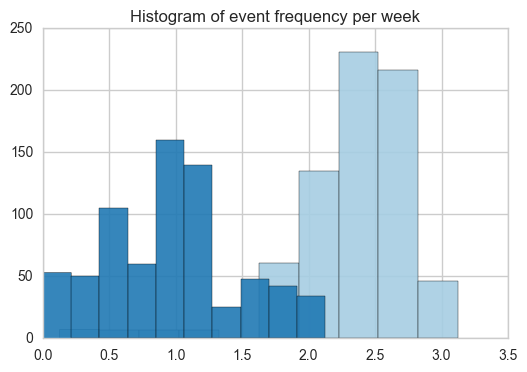

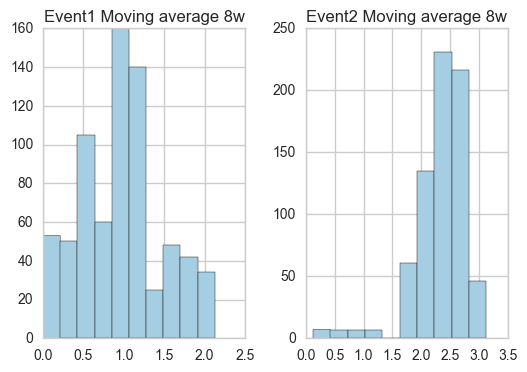

(<matplotlib.axes._subplots.AxesSubplot at 0x10b530d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b530d30>)

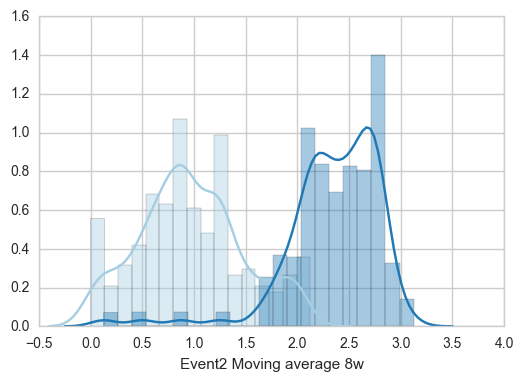

In [166]:
# joint histograms
plt.figure()
df['Event2 Moving average 8w'].hist(alpha=.9)
df['Event1 Moving average 8w'].hist(alpha=.9)
plt.title('Histogram of event frequency per week')
plt.show()

#%% histograms side-by-side
df.loc[:,['Event2 Moving average 8w', 'Event1 Moving average 8w']].hist()
plt.show()

# With seaborn
sns.distplot(df['Event1 Moving average 8w']), \
sns.distplot(df['Event2 Moving average 8w'])